In [1]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

In [3]:
db = client.adsE_database
collection = db.adsE_collection

### prepare data for prediction ###

In [4]:
elements = ['Ag', 'Al', 'Au', 'Cu', 'Pt', 'Pd', 'Ni', 'Rh']
faces = ['100', '111', '110', '211']

dictlis = []

for ele in elements:
    for face in faces:
        dicte = {'element':ele, 'face':face}
        dictlis.append(dicte)

dictlis.append({'element':'CoPt3', 'face':'100'})
dictlis.append({'element':'GaNi', 'face':'110'})

In [5]:
inst = []
dfall = []
df = []
dfpred = []

for i in range(len(dictlis)):
    try:
        inst.append(dataset_utilizer(**dictlis[i]))
        dfall.append(inst[i].dfall)
        df.append(inst[i].df)
        dfpred.append(inst[i].dfpred)
    except:
        print('Error: {0}'.format(dictlis[i]))

In [6]:
### Exclude coverage > 1.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['coverage'] <= 1.0]

### Exclude ads ene > 2.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['aveadsE/suratom'] >= -2.0]

In [7]:
covset = []
for i in range(len(dfpred)):
    covset.append(sorted(list(set(dfpred[i]['coverage']))))
# covset

### Just show residue ####

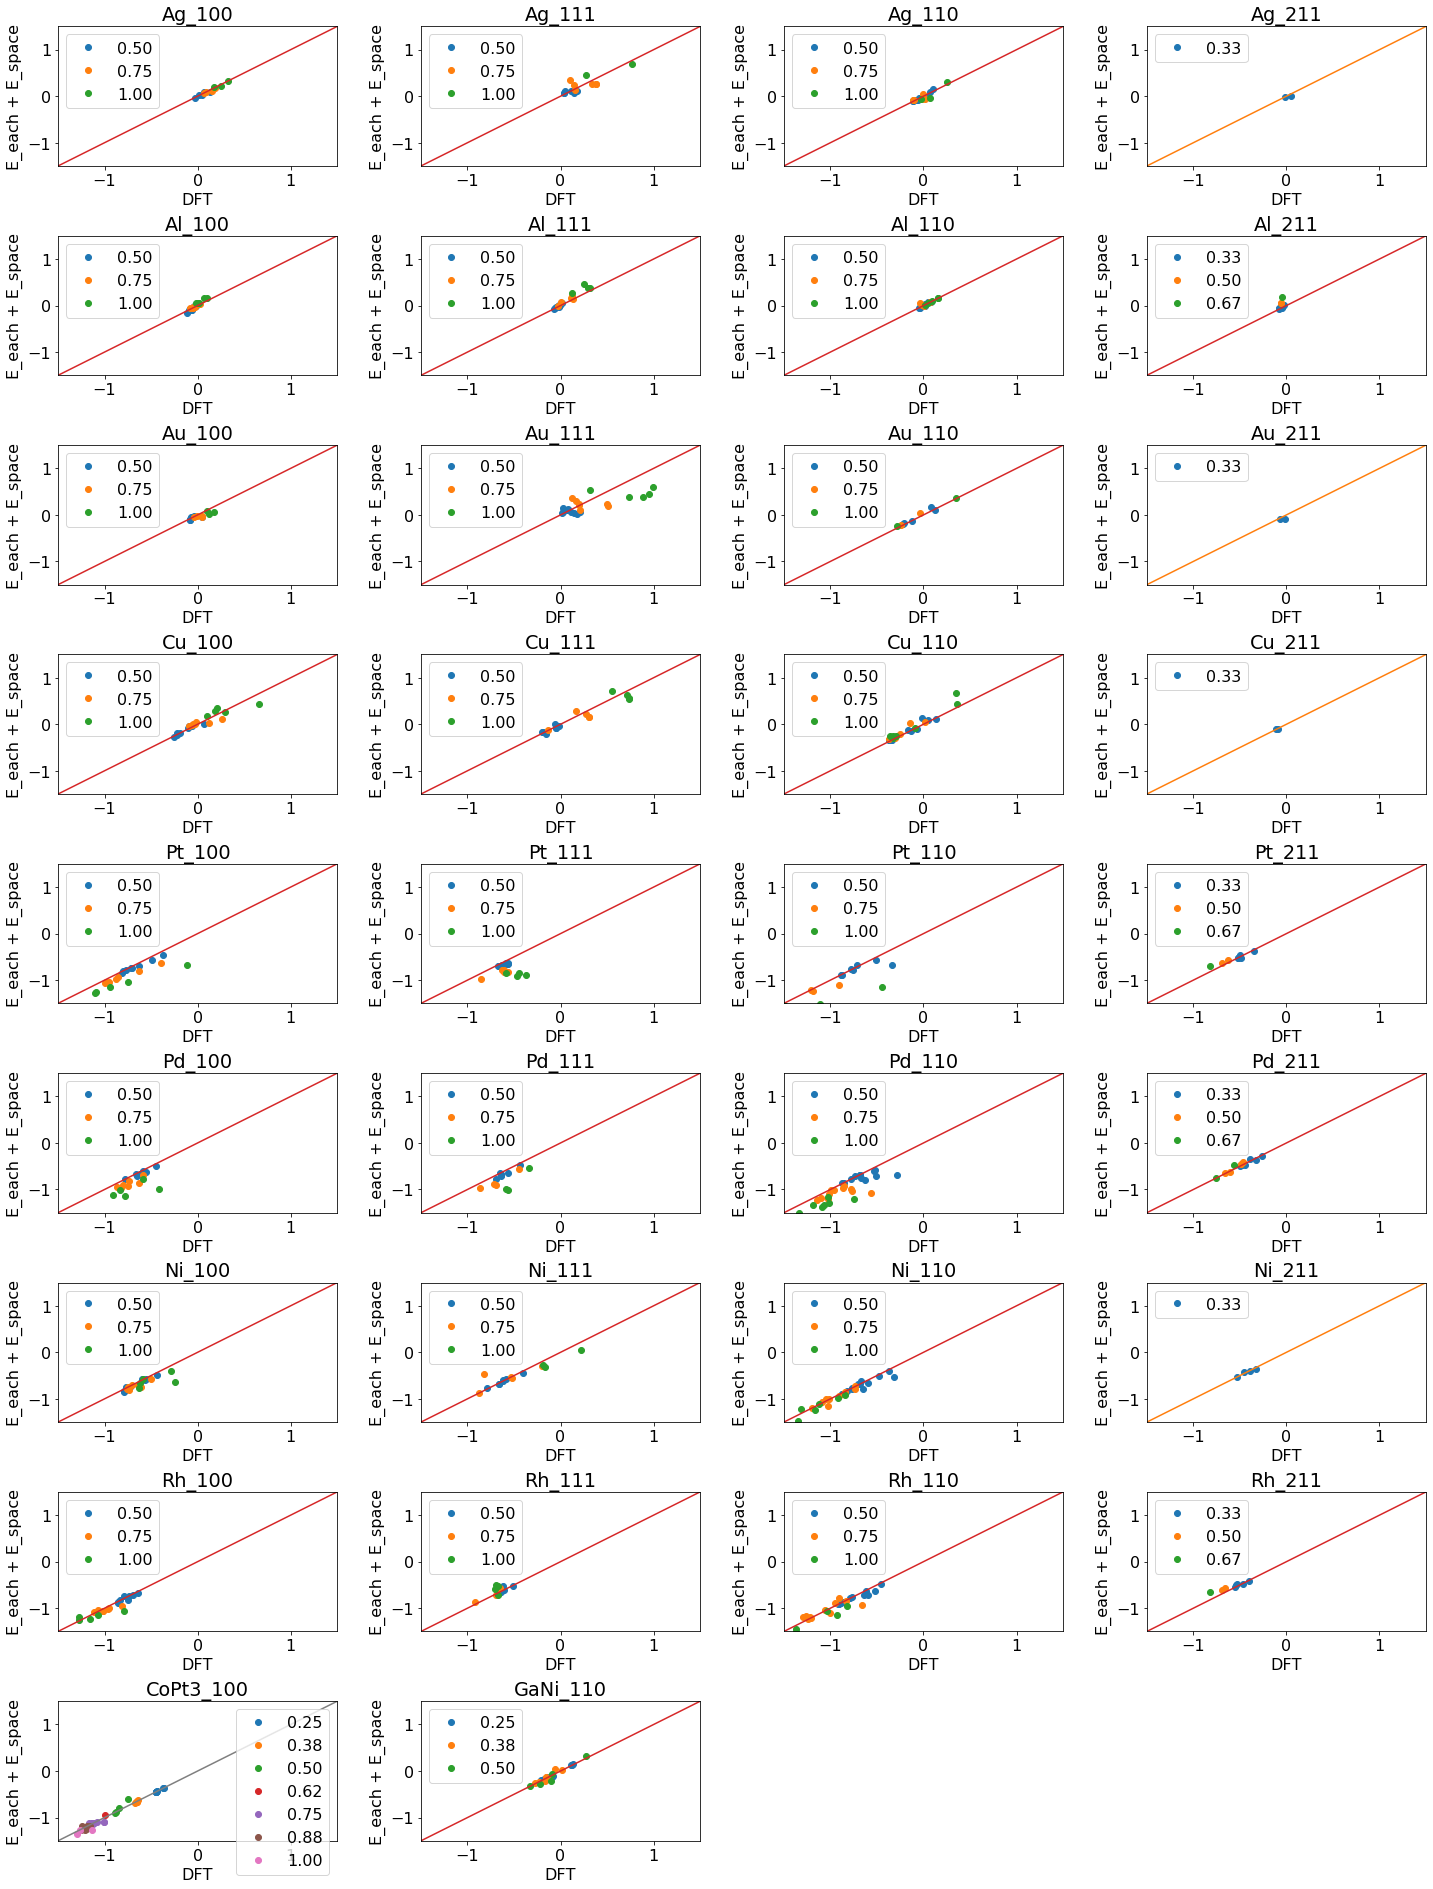

In [9]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(20,30))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(9, 4, i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        if not covset[i][j]:
            continue
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        aveadsE_suratom = np.array(data['aveadsE/suratom'])
        E_residue = np.array(data['E_residue/suratom'])
        E_prepred = aveadsE_suratom - E_residue
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_prepred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
plt.savefig('E_residue.png', bbox_inches='tight')
# plt.show()

In [10]:
dfall[14][dfall[14]['numberofads']==1]

,_id,name,isvalid,ispredictable,element,face,unitlength,xc,adsorbate,numberofads,coverage,surfatomnum,E,bareE,E_ads,totaladsE,aveadsE/suratom,aveadsE/ads,E_int_space,sumE_each_ads,E_residue/suratom,area,density,igroups,rgroups,converged,is_adsorbed,kept_sites,E_not_exceeded,minimum_distance,ads_dist2,ads_dist3
0,5e7cbc9e0a0ea2c2e6ad4dd0,Cu_110_u2_RPBE_no001_CO_n1_d8.traj,yes,No,Cu,110,2,RPBE,CO,1,0.25,4,-60.883724,-45.728397,-14.485436,-0.669890,-0.167473,-0.669890,0.000815,NaN,NaN,38.24561,0.026147,[0],[0],yes,yes,yes,yes,None,NaN,NaN
1,5e7cbc9e0a0ea2c2e6ad4dd2,Cu_110_u2_RPBE_no002_CO_n1_d8.traj,yes,No,Cu,110,2,RPBE,CO,1,0.25,4,-60.895381,-45.728397,-14.485436,-0.681548,-0.170387,-0.681548,0.000815,NaN,NaN,38.24561,0.026147,[1],[1],yes,yes,yes,yes,None,NaN,NaN
3,5e7cbca20a0ea2c2e6ad4dd6,Cu_110_u2_RPBE_no003_CO_n1_d8.traj,yes,No,Cu,110,2,RPBE,CO,1,0.25,4,-59.969775,-45.728397,-14.485436,0.244059,0.061015,0.244059,0.000815,NaN,NaN,38.24561,0.026147,[2],[2],yes,yes,yes,yes,None,NaN,NaN
5,5e7cbca60a0ea2c2e6ad4dda,Cu_110_u2_RPBE_no004_CO_n1_d8.traj,yes,No,Cu,110,2,RPBE,CO,1,0.25,4,-60.419677,-45.728397,-14.485436,-0.205844,-0.051461,-0.205844,0.000815,NaN,NaN,38.24561,0.026147,[3],[3],yes,yes,yes,yes,None,NaN,NaN


In [11]:
query('Cu_110_u2_RPBE_no004_CO_n1_d8.traj','local')

Atoms(symbols='Cu16CO', pbc=True, cell=[[5.200358657806353, 0.0, 3e-16], [1.2e-15, 7.35441774307409, 5e-16], [0.0, 0.0, 31.20215194683812]], constraint=FixAtoms(indices=[0, 2, 4, 6, 8, 10, 12, 14]), calculator=SinglePointCalculator(...))

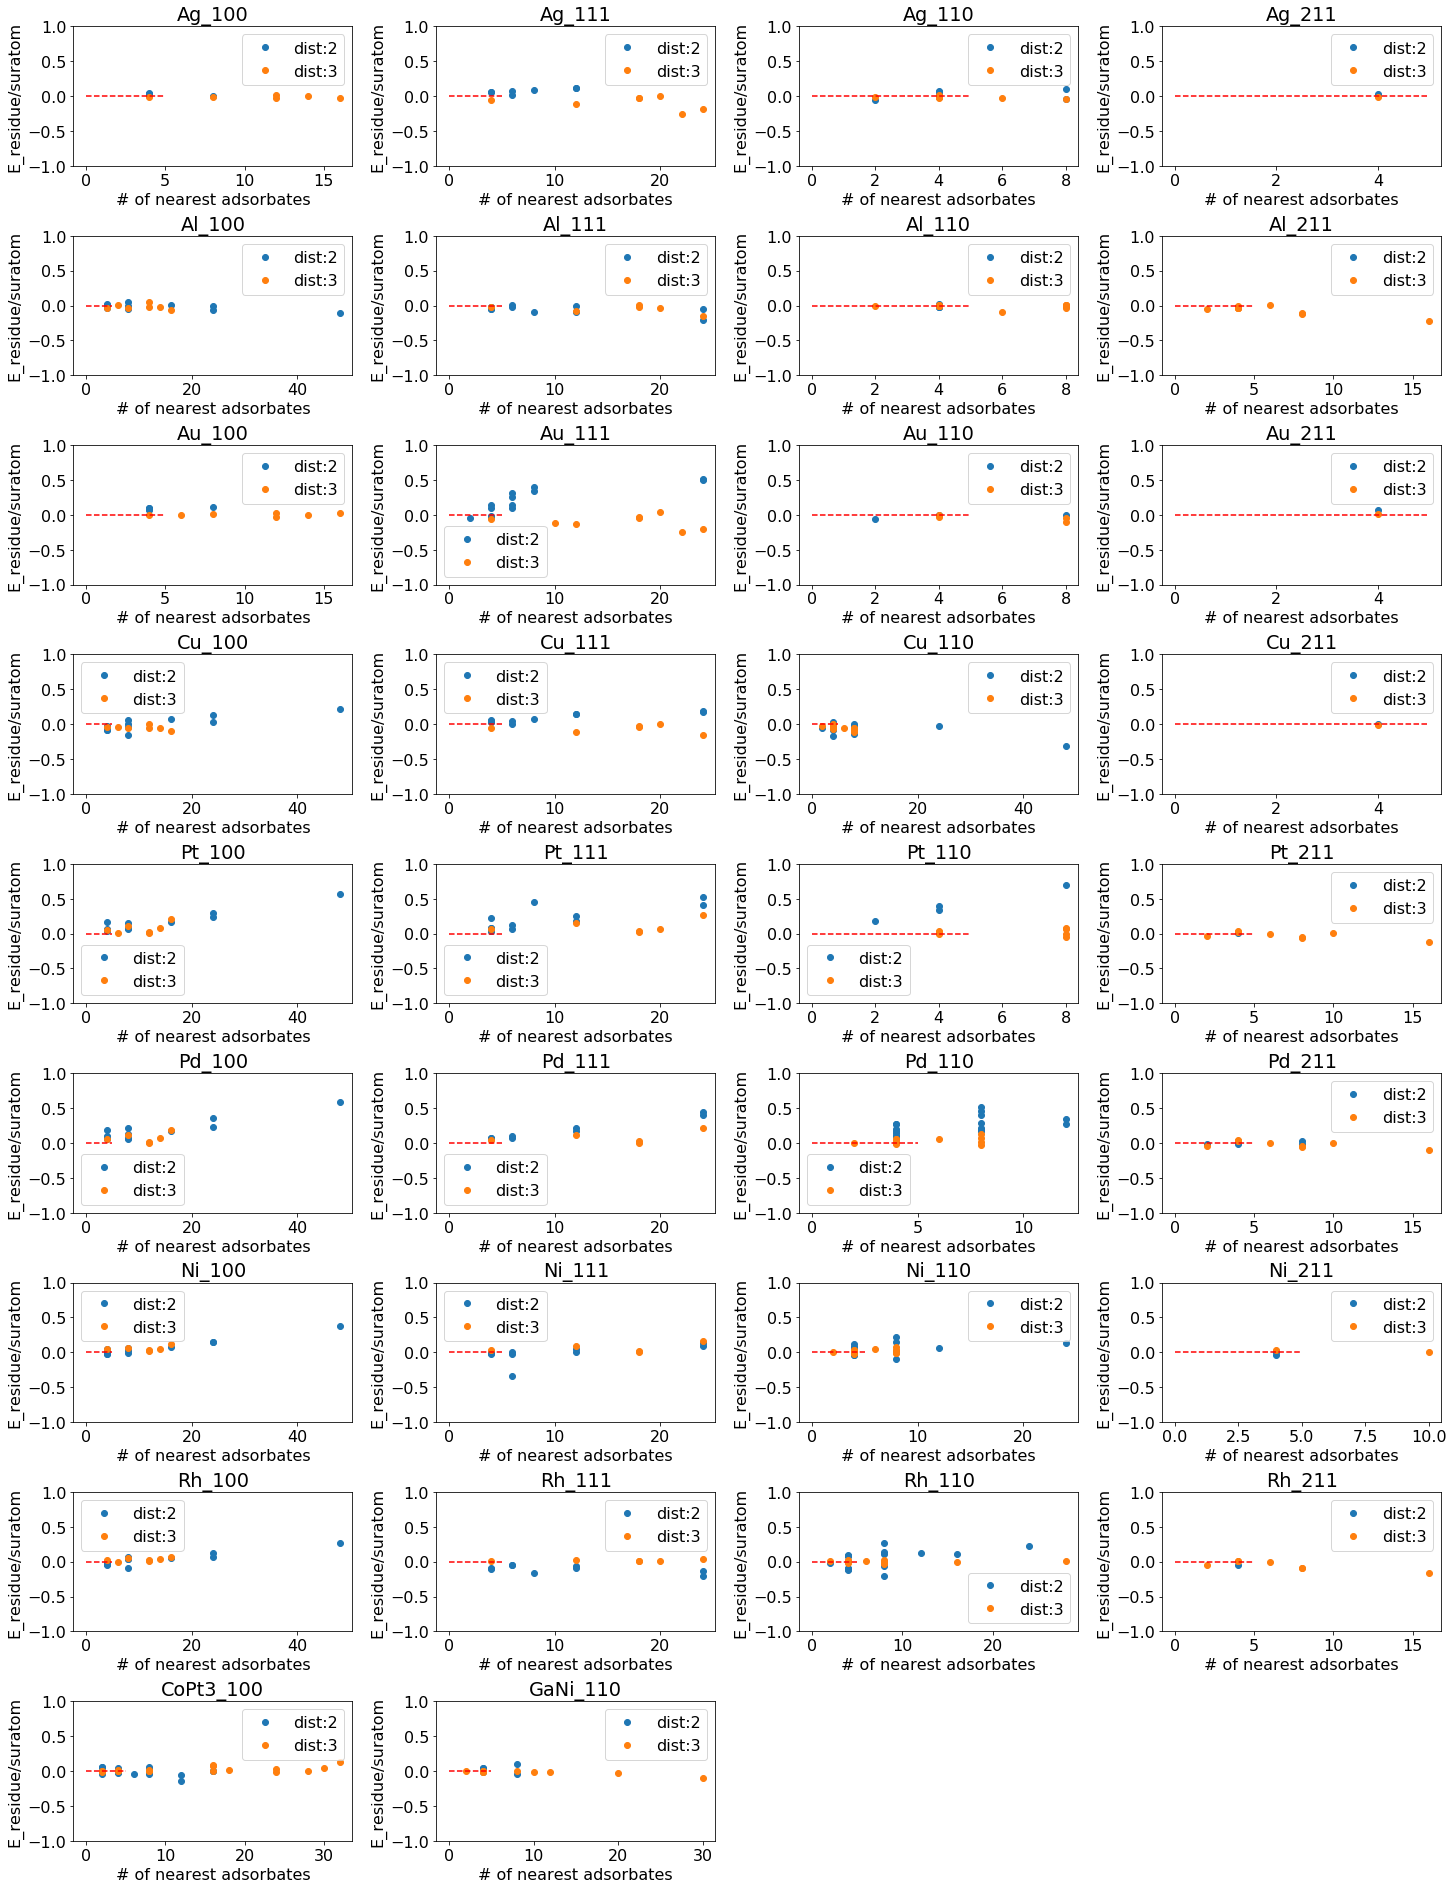

In [12]:
fig = plt.figure(figsize=(20,30))
plt.rcParams["font.size"] = 16


xmin = 0
xmax = 5
for i in range(len(dfpred)):
    ax = fig.add_subplot(9, 4, i+1)
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==2]['ads_dist2'], dfpred[i][dfpred[i]['minimum_distance']==2]['E_residue/suratom'], 'o')
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==3]['ads_dist3'], dfpred[i][dfpred[i]['minimum_distance']==3]['E_residue/suratom'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('E_residue/suratom')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:2','dist:3'])
# plt.savefig('')
  #  plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

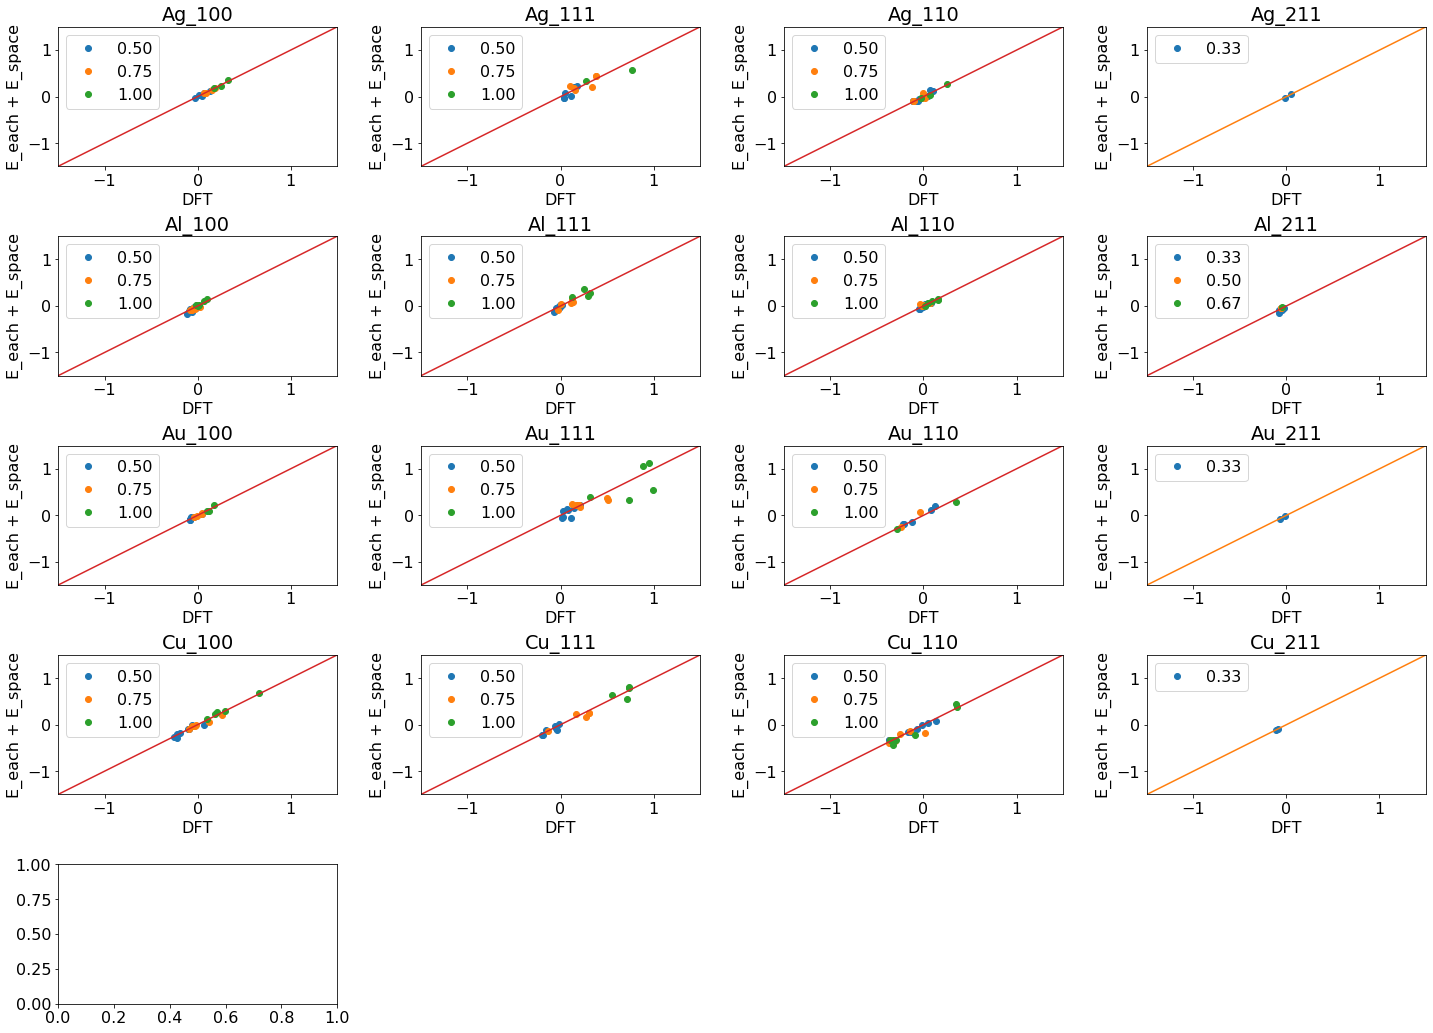

In [177]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(20,30))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(9, 4, i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        weight2, weight3 = inst[i].fit_weight_from_specific_element_and_face()
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        
        E_residue_pred = data['ads_dist2'] * weight2 + data['ads_dist3'] * weight3
        E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred

        aveadsE_suratom = data['aveadsE/suratom']
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_ads_pred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
plt.savefig('E_pred_wmf.png', bbox_inches='tight')
# plt.show()

In [149]:
dfall[14]

,_id,name,isvalid,ispredictable,element,face,unitlength,xc,adsorbate,numberofads,coverage,surfatomnum,E,bareE,E_ads,totaladsE,aveadsE/suratom,aveadsE/ads,E_int_space,sumE_each_ads,E_residue/suratom,area,density,igroups,rgroups,converged,is_adsorbed,kept_sites,E_not_exceeded,minimum_distance,ads_dist2,ads_dist3
0,5e7510c3f215505f6e704574,Cu_110_u2_RPBE_no001_CO_n1_d8.traj,yes,No,Cu,110,2,RPBE,CO,1,0.25,4,-60.883724,-45.728397,-14.485436,-0.669890,-0.167473,-0.669890,0.000815,NaN,NaN,38.24561,0.026147,[0],[0],yes,yes,yes,yes,None,NaN,NaN
1,5e7510c3f215505f6e704576,Cu_110_u2_RPBE_no002_CO_n1_d8.traj,yes,No,Cu,110,2,RPBE,CO,1,0.25,4,-60.895381,-45.728397,-14.485436,-0.681548,-0.170387,-0.681548,0.000815,NaN,NaN,38.24561,0.026147,[1],[1],yes,yes,yes,yes,None,NaN,NaN
2,5e7510c4f215505f6e704578,Cu_110_u2_RPBE_no002_CO_n2_d5.traj,yes,yes,Cu,110,2,RPBE,CO,2,0.50,4,-76.169584,-45.728397,-14.485436,-1.470314,-0.367578,-0.735157,0.006703,-1.339781,-0.034309,38.24561,0.052294,"[0, 0]","[0, 0]",yes,yes,yes,yes,Over 4,0.000000,0.000000
3,5e7510c7f215505f6e70457a,Cu_110_u2_RPBE_no003_CO_n1_d8.traj,yes,No,Cu,110,2,RPBE,CO,1,0.25,4,-59.969775,-45.728397,-14.485436,0.244059,0.061015,0.244059,0.000815,NaN,NaN,38.24561,0.026147,[2],[2],yes,yes,yes,yes,None,NaN,NaN
4,5e7510c8f215505f6e70457c,Cu_110_u2_RPBE_no003_CO_n3_d3.traj,yes,yes,Cu,110,2,RPBE,CO,3,0.75,4,-90.638946,-45.728397,-14.485436,-1.454240,-0.363560,-0.484747,0.826986,-2.009671,-0.067889,38.24561,0.078440,"[0, 0, 0]","[0, 0, 0]",yes,yes,yes,yes,3,0.000000,0.666667
5,5e7510ccf215505f6e70457e,Cu_110_u2_RPBE_no004_CO_n1_d8.traj,yes,No,Cu,110,2,RPBE,CO,1,0.25,4,-60.419677,-45.728397,-14.485436,-0.205844,-0.051461,-0.205844,0.000815,NaN,NaN,38.24561,0.026147,[3],[3],yes,yes,yes,yes,None,NaN,NaN
6,5e7510ccf215505f6e704580,Cu_110_u2_RPBE_no004_CO_n4_d3.traj,yes,yes,Cu,110,2,RPBE,CO,4,1.00,4,-105.123068,-45.728397,-14.485436,-1.452926,-0.363232,-0.363232,1.685072,-2.679562,-0.114609,38.24561,0.104587,"[0, 0, 0, 0]","[0, 0, 0, 0]",yes,yes,yes,yes,3,0.000000,1.333333
7,5e7510d0f215505f6e704582,Cu_110_u2_RPBE_no005_CO_n3_d3.traj,yes,yes,Cu,110,2,RPBE,CO,3,0.75,4,-90.682397,-45.728397,-14.485436,-1.497691,-0.374423,-0.499230,0.274480,-1.545625,-0.056636,38.24561,0.078440,"[3, 0, 0]","[3, 0, 0]",yes,yes,yes,yes,3,0.000000,0.666667
8,5e7510d4f215505f6e704584,Cu_110_u2_RPBE_no006_CO_n4_d3.traj,yes,yes,Cu,110,2,RPBE,CO,4,1.00,4,-104.985101,-45.728397,-14.485436,-1.314958,-0.328740,-0.328740,0.584352,-1.751469,-0.036960,38.24561,0.104587,"[3, 3, 0, 0]","[3, 3, 0, 0]",yes,yes,yes,yes,2,1.000000,1.333333
9,5e7510d8f215505f6e704586,Cu_110_u2_RPBE_no007_CO_n2_d5.traj,yes,yes,Cu,110,2,RPBE,CO,2,0.50,4,-75.361126,-45.728397,-14.485436,-0.661856,-0.165464,-0.330928,0.811936,-1.339781,-0.033503,38.24561,0.052294,"[0, 0]","[0, 0]",yes,yes,yes,yes,3,0.000000,0.666667


In [150]:
query('Cu_110_u2_RPBE_no003_CO_n1_d8_all.traj','local')

Atoms(symbols='Cu16CO', pbc=True, cell=[5.20035866, 7.35441774, 31.20215195], constraint=FixAtoms(indices=[0, 2, 4, 6, 8, 10, 12, 14]), calculator=SinglePointCalculator(...))

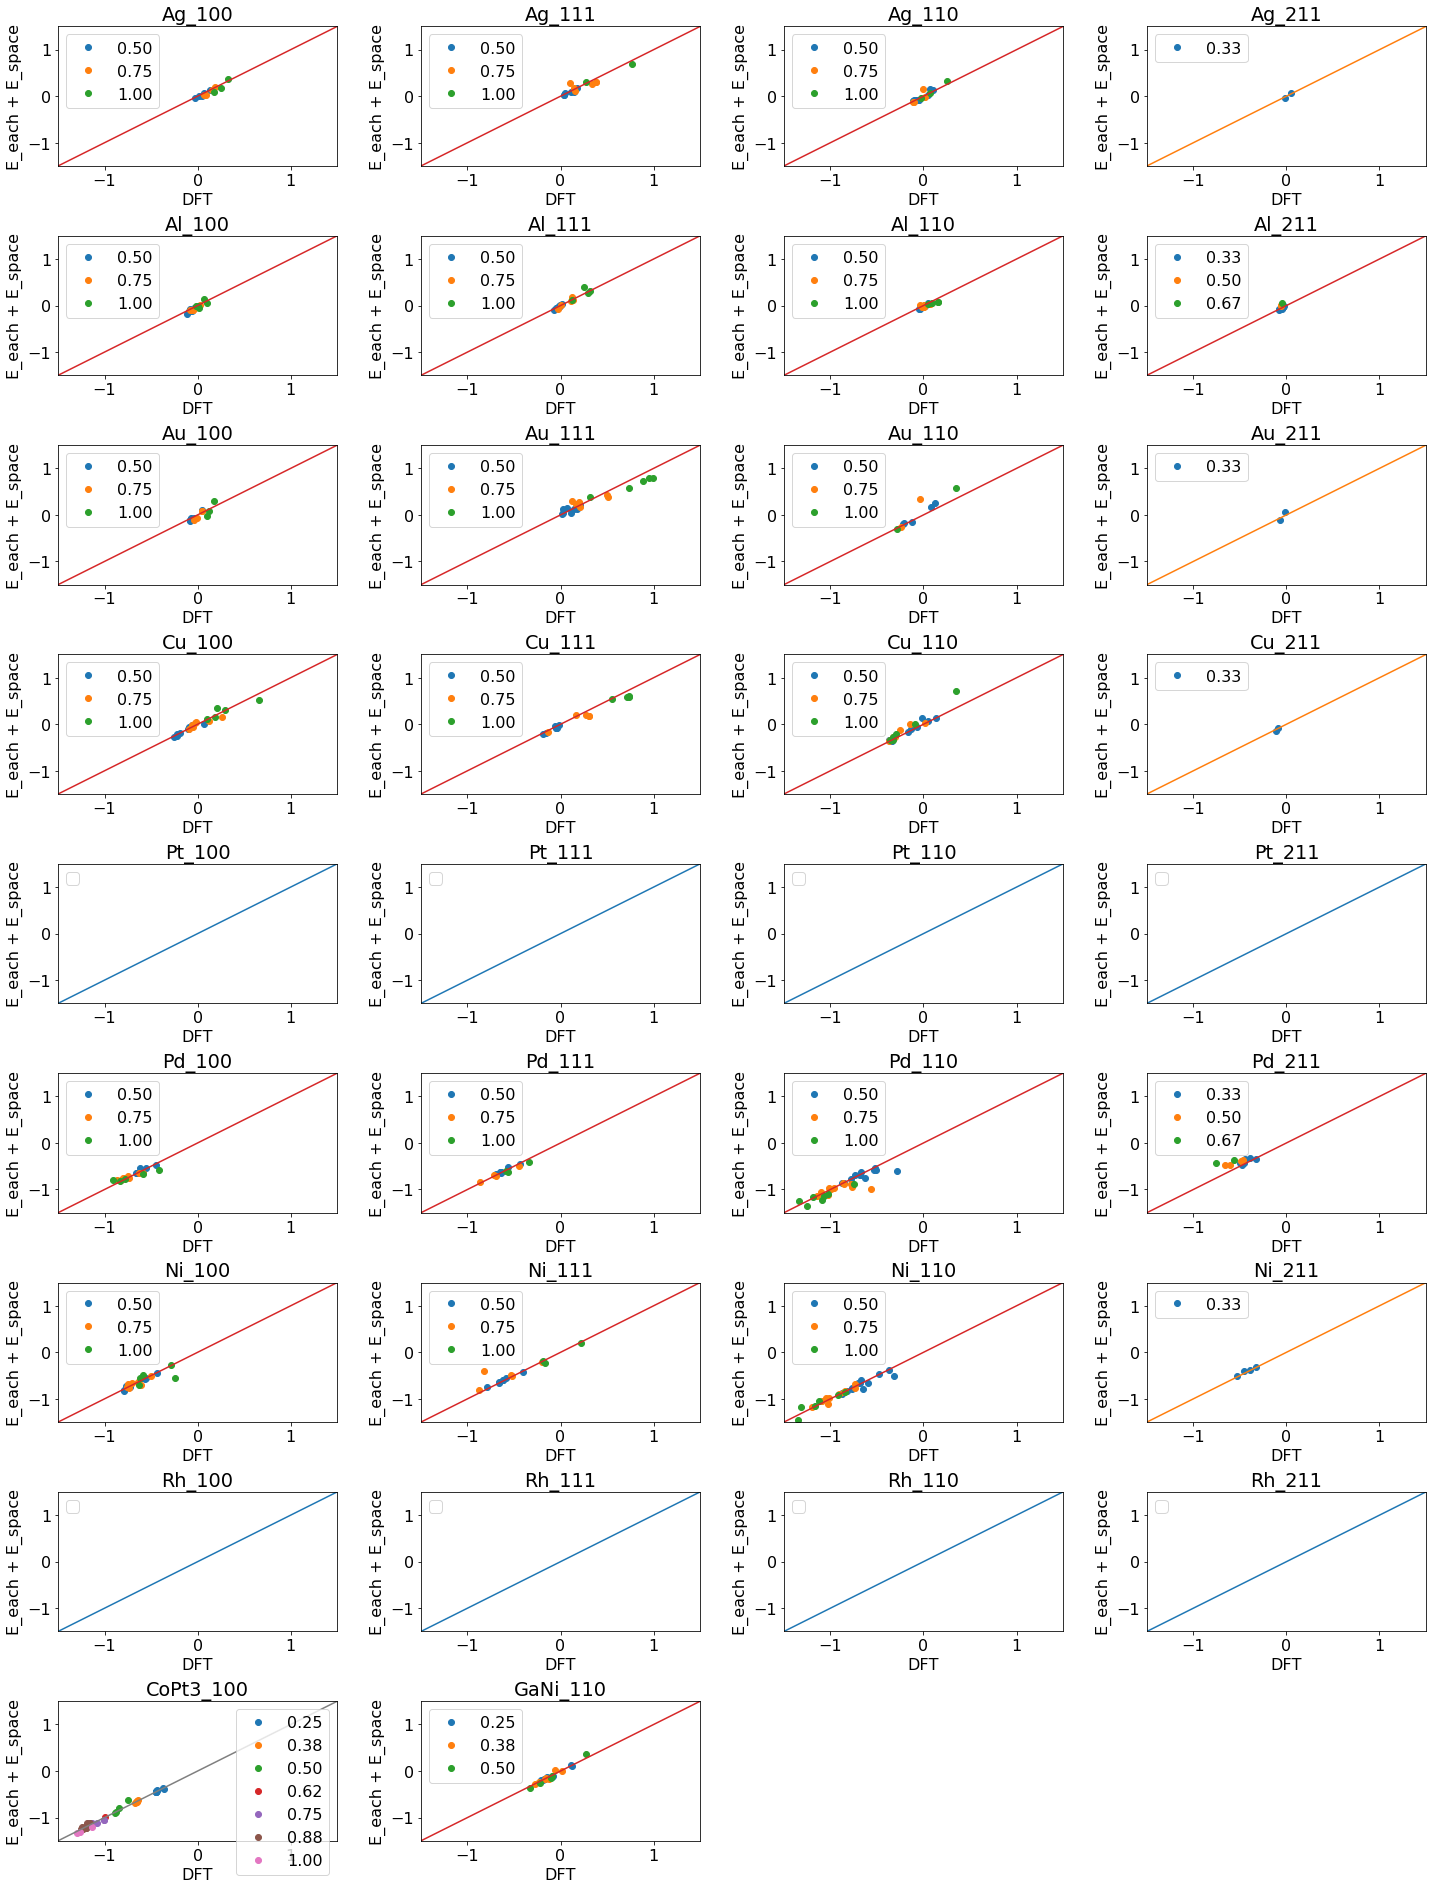

In [13]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(20,30))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(9, 4, i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        print
        weight2, weight3 = inst[i].fit_weight_from_specific_element()
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        
        E_residue_pred = data['ads_dist2'] * weight2 + data['ads_dist3'] * weight3
        E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred

        aveadsE_suratom = data['aveadsE/suratom']
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_ads_pred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
# plt.show()

In [140]:
dfall[22]

,_id,name,isvalid,ispredictable,element,face,unitlength,xc,adsorbate,numberofads,coverage,surfatomnum,E,bareE,E_ads,totaladsE,aveadsE/suratom,aveadsE/ads,E_int_space,sumE_each_ads,E_residue/suratom,area,density,igroups,rgroups,converged,is_adsorbed,kept_sites,E_not_exceeded,minimum_distance,ads_dist2,ads_dist3
0,5e751740f215505f6e704716,Pd_110_u2_RPBE_no001_CO_n1_d9.traj,yes,No,Pd,110,2,RPBE,CO,1,0.25,4,-82.129925,-66.27899,-14.485436,-1.365499,-0.341375,-1.365499,0.000173,NaN,NaN,44.804448,0.022319,[0],[0],yes,yes,yes,yes,None,NaN,NaN
1,5e751740f215505f6e704718,Pd_110_u2_RPBE_no002_CO_n1_d9.traj,yes,No,Pd,110,2,RPBE,CO,1,0.25,4,-82.490285,-66.27899,-14.485436,-1.725859,-0.431465,-1.725859,0.000173,NaN,NaN,44.804448,0.022319,[1],[1],yes,yes,yes,yes,None,NaN,NaN
2,5e751741f215505f6e70471a,Pd_110_u2_RPBE_no003_CO_n1_d9.traj,yes,No,Pd,110,2,RPBE,CO,1,0.25,4,-82.342780,-66.27899,-14.485436,-1.578353,-0.394588,-1.578353,0.000173,NaN,NaN,44.804448,0.022319,[2],[2],yes,yes,yes,yes,None,NaN,NaN
3,5e751741f215505f6e70471c,Pd_110_u2_RPBE_no004_CO_n1_d9.traj,yes,No,Pd,110,2,RPBE,CO,1,0.25,4,-82.178244,-66.27899,-14.485436,-1.413818,-0.353454,-1.413818,0.000173,NaN,NaN,44.804448,0.022319,[3],[3],yes,yes,yes,yes,None,NaN,NaN
4,5e7819ccf215505f6e704f50,Pd_110_u2_RPBE_no002_CO_n2_d5.traj,yes,yes,Pd,110,2,RPBE,CO,2,0.50,4,-97.975608,-66.27899,-14.485436,-2.725746,-0.681436,-1.362873,-0.008954,-2.730998,0.003552,44.804448,0.044638,"[0, 0]","[0, 0]",yes,yes,yes,yes,Over 4,0.000000,0.000000
5,5e7819d0f215505f6e704f53,Pd_110_u2_RPBE_no003_CO_n3_d3.traj,yes,yes,Pd,110,2,RPBE,CO,3,0.75,4,-113.173348,-66.27899,-14.485436,-3.438049,-0.859512,-1.146016,0.408087,-4.096497,0.062590,44.804448,0.066958,"[0, 0, 0]","[0, 0, 0]",yes,yes,yes,yes,3,0.000000,0.666667
6,5e7819d3f215505f6e704f56,Pd_110_u2_RPBE_no004_CO_n4_d3.traj,yes,yes,Pd,110,2,RPBE,CO,4,1.00,4,-128.340816,-66.27899,-14.485436,-4.120081,-1.030020,-1.030020,0.841667,-5.461997,0.125062,44.804448,0.089277,"[0, 0, 0, 0]","[0, 0, 0, 0]",yes,yes,yes,yes,3,0.000000,1.333333
7,5e7819d7f215505f6e704f58,Pd_110_u2_RPBE_no005_CO_n3_d3.traj,yes,yes,Pd,110,2,RPBE,CO,3,0.75,4,-113.727927,-66.27899,-14.485436,-3.992628,-0.998157,-1.330876,0.089034,-4.144816,0.015788,44.804448,0.066958,"[3, 0, 0]","[3, 0, 0]",yes,yes,yes,yes,3,0.000000,0.666667
8,5e7819dbf215505f6e704f5a,Pd_110_u2_RPBE_no006_CO_n4_d3.traj,yes,yes,Pd,110,2,RPBE,CO,4,1.00,4,-128.484501,-66.27899,-14.485436,-4.263766,-1.065942,-1.065942,0.216964,-5.558633,0.269476,44.804448,0.089277,"[3, 3, 0, 0]","[3, 3, 0, 0]",yes,yes,yes,yes,2,1.000000,1.333333
9,5e7819dff215505f6e704f5c,Pd_110_u2_RPBE_no007_CO_n2_d5.traj,yes,yes,Pd,110,2,RPBE,CO,2,0.50,4,-97.329169,-66.27899,-14.485436,-2.079306,-0.519827,-1.039653,0.412164,-2.730998,0.059882,44.804448,0.044638,"[0, 0]","[0, 0]",yes,yes,yes,yes,3,0.000000,0.666667


In [145]:
query('Pd_110_u2_RPBE_no002_CO_n1_d9.traj','local')

Atoms(symbols='Pd16CO', pbc=[True, True, False], cell=[[5.628634752123995, 0.0, 3e-16], [1.3e-15, 7.960091604098278, 5e-16], [0.0, 0.0, 33.77180851274397]], tags=..., constraint=FixAtoms(indices=[0, 2, 4, 6, 8, 10, 12, 14]), calculator=SinglePointCalculator(...))

In [88]:
def get_adsorb_zdistance(atoms, adsorbate):
    '''
    Return maximum of minimum distance between each adsorbates and surface
    '''
    adseles = get_all_elements(adsorbate)
    baresurface, adsites = remove_adsorbate(atoms, adseles)
    mindists = []
    for pos in adsites:
        posdiff = pos - baresurface.positions
        minzdist = np.amin(posdiff, axis=0)[2]
        mindists.append(minzdist)
    maxdist = max(mindists)
    return maxdist

In [89]:
atoms = query('Pd_110_u2_RPBE_no028_CO_n4_d3.traj')
adsorbate = query('CO_RPBE.traj')

In [90]:
np.min(get_adsorb_zdistance(atoms, adsorbate))

1.1932615464275287